In [1]:

from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI

llm= ChatOpenAI(
    model="gpt-4.1-mini-2025-04-14",
    api_key=api_key,
)


In [3]:
llm.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'chatcmpl-BkAEJPm6wQ69TtTfaSEZnAieUmdsN', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--9d4408ac-2b31-4b9b-b784-2df298145e06-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [4]:
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.utilities.sql_database import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///ecommerce.db")

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

In [ ]:
from sqlalchemy.engine import Result
from pydantic import BaseModel, Field
from typing import Any, Dict, Optional, Sequence, Type, Union
from langchain_core.callbacks import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
from langchain_core.tools import BaseTool
from pydantic import BaseModel, Field, root_validator, model_validator, ConfigDict

class BaseSQLDatabaseTool(BaseModel):
    """Base tool for interacting with a SQL database."""

    db: SQLDatabase = Field(exclude=True)

    model_config = ConfigDict(
        arbitrary_types_allowed=True,
    )


class _QuerySQLDatabaseToolInput(BaseModel):
    query: str = Field(..., description="A detailed and correct SQL query.")


class QuerySQLDatabaseTool(BaseSQLDatabaseTool, BaseTool):
    """Tool for querying a SQL database.

    .. versionchanged:: 0.3.12

        Renamed from QuerySQLDataBaseTool to QuerySQLDatabaseTool.
        Legacy name still works for backwards compatibility.
    """

    name: str = "sql_db_query"
    description: str = """
    Execute a SQL query against the database and get back the result..
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    args_schema: Type[BaseModel] = _QuerySQLDatabaseToolInput

    def _run(
        self,
        query: str,
        run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> Union[str, Sequence[Dict[str, Any]], Result]:
        """Execute the query, return the results or an error message."""

        if not query.strip().lower().startswith("select"):
            return "This tool can only be used to execute SELECT queries. not INSERT, UPDATE, DELETE, or other types of queries."
    
        return self.db.run_no_throw(query)

In [20]:
Custom_tool=QuerySQLDatabaseTool(db=db, description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.")

In [24]:
new_tool_kit=toolkit.get_tools()[1:]+[Custom_tool]

In [25]:
new_tool_kit

[InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001FFE735EAE0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001FFE735EAE0>),
 QuerySQLCheckerTool(description='Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001FFE735EAE0>, llm=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001FFE89C58B0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001FFE9DB3EC0>, root_client=<openai.OpenAI object at 0x000001FFE8

In [6]:
from langchain_community.agent_toolkits import create_sql_agent

agent_executor = create_sql_agent(llm, db=db, agent_type="tool-calling", verbose=True)


agent_executor.invoke(
    {
        "input": "What is the total revenue generated by each product category?"
    }
)



> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{}`


customers, order_items, orders, products, suppliers
Invoking: `sql_db_schema` with `{'table_names': 'order_items, products'}`



CREATE TABLE order_items (
	item_id INTEGER, 
	order_id INTEGER, 
	product_id INTEGER, 
	quantity INTEGER, 
	unit_price DECIMAL(10, 2), 
	discount DECIMAL(5, 2), 
	PRIMARY KEY (item_id), 
	FOREIGN KEY(order_id) REFERENCES orders (order_id), 
	FOREIGN KEY(product_id) REFERENCES products (product_id)
)

/*
3 rows from order_items table:
item_id	order_id	product_id	quantity	unit_price	discount
1	1	1	1	999.99	0.00
2	1	6	5	49.99	5.00
3	2	2	1	699.99	0.00
*/


CREATE TABLE products (
	product_id INTEGER, 
	product_name TEXT NOT NULL, 
	category TEXT, 
	price DECIMAL(10, 2), 
	stock_quantity INTEGER, 
	supplier_id INTEGER, 
	rating DECIMAL(3, 2), 
	PRIMARY KEY (product_id)
)

/*
3 rows from products table:
product_id	product_name	category	price	stock_quantity	supplier_id	rating
1

{'input': 'What is the total revenue generated by each product category?',
 'output': 'The total revenue generated by each product category is as follows:\n- Electronics: $4492.34\n- Appliances: $329.97\n- Furniture: $249.99\n- Sports: $79.98\n- Food: $69.97\n\nIf you need more details or information on any specific category, feel free to ask!'}

Testing bar chart:


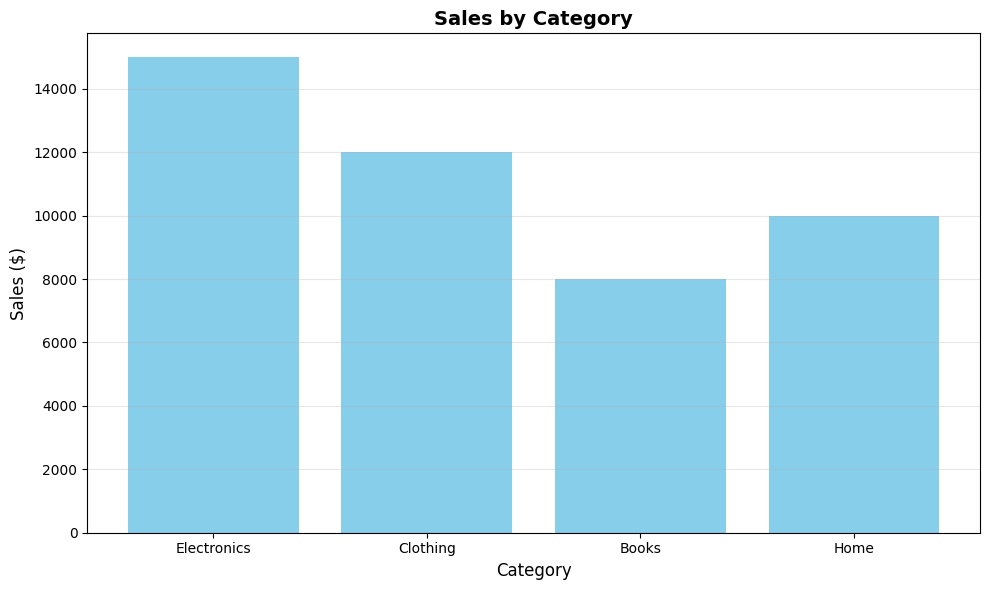


Testing line chart:


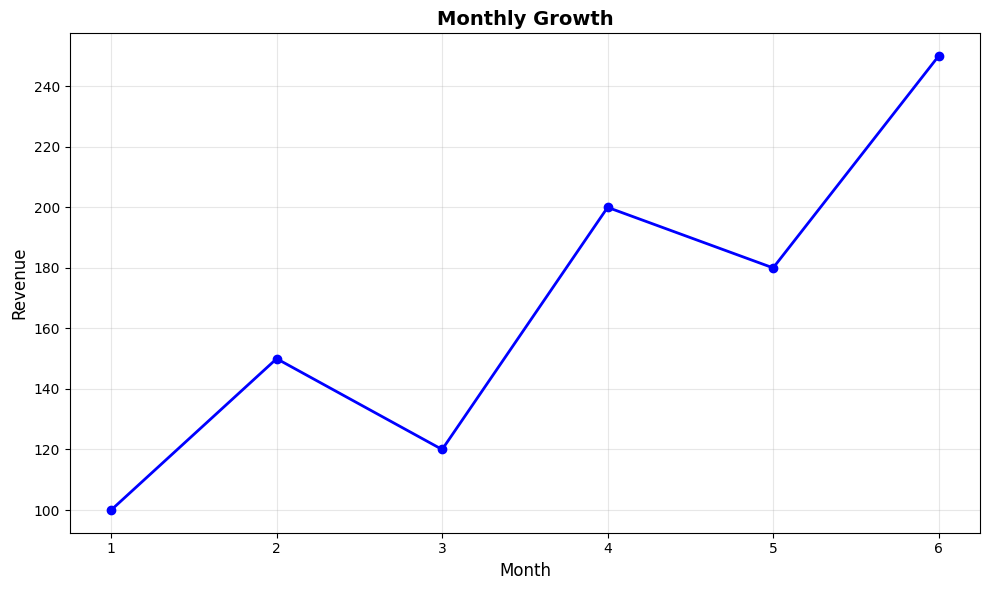


Testing histogram:


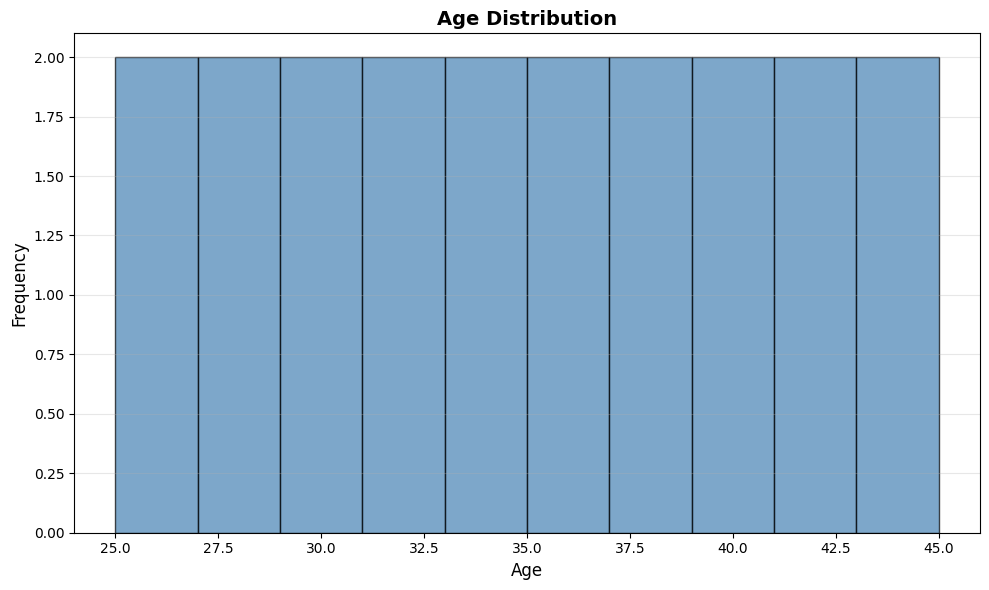


Testing scatter plot:


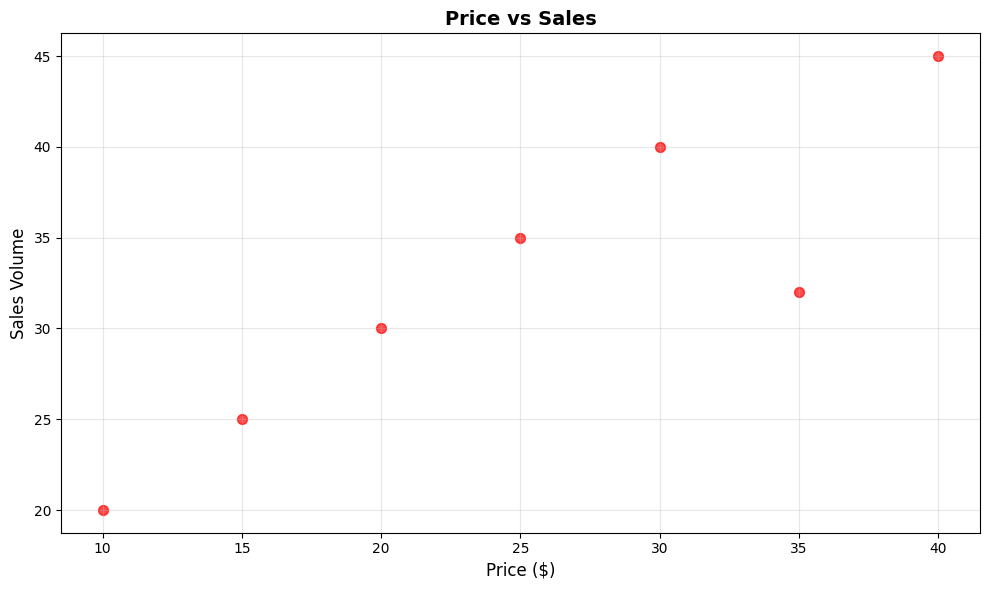


Testing pie chart:


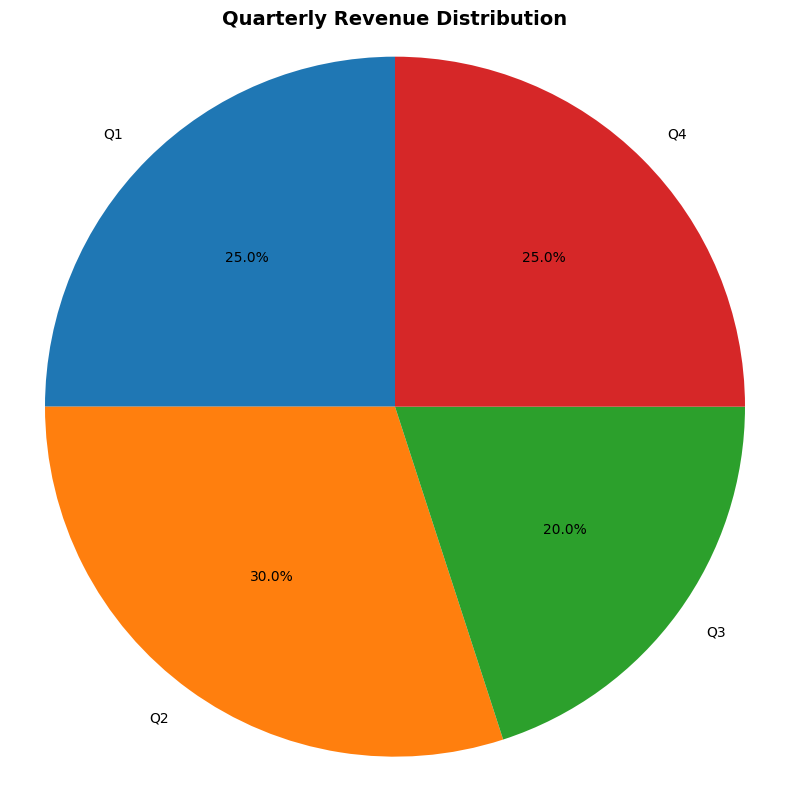


All chart functions tested successfully!


In [ ]:
import pandas as pd
import io
import base64
import matplotlib.pyplot as plt
import numpy as np

def create_bar_chart(data, title="Bar Chart", color='skyblue', xlabel="Category", ylabel="Value"):
    """
    Create a bar chart from list data
    
    Args:
        data (list): List of [category, value] pairs, e.g., [['A', 23], ['B', 45], ['C', 56]]
                    If empty or None, default sample data will be used
        title (str): Title for the chart (default: "Bar Chart")
        color (str): Bar color (default: 'skyblue')
        xlabel (str): X-axis label (default: "Category")
        ylabel (str): Y-axis label (default: "Value")
    
    Returns:
        str: base64 encoded string of the plot image
    """
    if not data:
        data = [['A', 23], ['B', 45], ['C', 56], ['D', 78]]
    
    categories = [item[0] for item in data]
    values = [item[1] for item in data]
    
    plt.figure(figsize=(10, 6))
    plt.bar(categories, values, color=color)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', dpi=300, bbox_inches='tight')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.getvalue()).decode()
    plt.show()
    plt.close()
    
    return image_base64

def create_line_chart(data, title="Line Chart", color='blue', xlabel="X", ylabel="Y"):
    """
    Create a line chart from list data
    
    Args:
        data (list): List of [x, y] pairs, e.g., [[1, 10], [2, 20], [3, 15]]
                    If empty or None, default sample data will be used
        title (str): Title for the chart (default: "Line Chart")
        color (str): Line color (default: 'blue')
        xlabel (str): X-axis label (default: "X")
        ylabel (str): Y-axis label (default: "Y")
    
    Returns:
        str: base64 encoded string of the plot image
    """
    if not data:
        x_vals = list(range(10))
        data = [[x, x**2] for x in x_vals]
    
    x_values = [item[0] for item in data]
    y_values = [item[1] for item in data]
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_values, marker='o', color=color, linewidth=2)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', dpi=300, bbox_inches='tight')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.getvalue()).decode()
    plt.show()
    plt.close()
    
    return image_base64

def create_histogram(data, bins=20, title="Histogram", color='steelblue', xlabel="Values"):
    """
    Create a histogram from list data
    
    Args:
        data (list): List of numeric values, e.g., [1, 2, 3, 4, 5, 2, 3, 1]
                    If empty or None, default sample data will be used
        bins (int): Number of bins for histogram (default: 20)
        title (str): Title for the chart (default: "Histogram")
        color (str): Bar color (default: 'steelblue')
        xlabel (str): X-axis label (default: "Values")
    
    Returns:
        str: base64 encoded string of the plot image
    """
    if not data:
        np.random.seed(42)
        data = list(np.random.normal(50, 15, 1000))
    
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, alpha=0.7, edgecolor='black', color=color)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', dpi=300, bbox_inches='tight')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.getvalue()).decode()
    plt.show()
    plt.close()
    
    return image_base64

def create_scatter_plot(data, title="Scatter Plot", color='red', xlabel="X", ylabel="Y"):
    """
    Create a scatter plot from list data
    
    Args:
        data (list): List of [x, y] pairs, e.g., [[1, 2], [3, 4], [5, 6]]
                    If empty or None, default sample data will be used
        title (str): Title for the chart (default: "Scatter Plot")
        color (str): Point color (default: 'red')
        xlabel (str): X-axis label (default: "X")
        ylabel (str): Y-axis label (default: "Y")
    
    Returns:
        str: base64 encoded string of the plot image
    """
    if not data:
        np.random.seed(42)
        data = [[np.random.normal(50, 15), np.random.normal(50, 15)] for _ in range(100)]
    
    x_values = [item[0] for item in data]
    y_values = [item[1] for item in data]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x_values, y_values, alpha=0.7, color=color, s=50)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', dpi=300, bbox_inches='tight')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.getvalue()).decode()
    plt.show()
    plt.close()
    
    return image_base64

def create_pie_chart(data, title="Pie Chart", colors=None):
    """
    Create a pie chart from list data
    
    Args:
        data (list): List of [label, value] pairs, e.g., [['A', 25], ['B', 35], ['C', 20]]
                    If empty or None, default sample data will be used
        title (str): Title for the chart (default: "Pie Chart")
        colors (list, optional): List of colors for slices (default: None for automatic colors)
    
    Returns:
        str: base64 encoded string of the plot image
    """
    if not data:
        data = [['Category A', 25], ['Category B', 35], ['Category C', 20], ['Category D', 20]]
    
    labels = [item[0] for item in data]
    values = [item[1] for item in data]
    
    plt.figure(figsize=(8, 8))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', dpi=300, bbox_inches='tight')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.getvalue()).decode()
    plt.show()
    plt.close()
    
    return image_base64



In [7]:
import asyncio
from autogen_agentchat.agents import CodeExecutorAgent

from autogen_ext.models.openai import OpenAIChatCompletionClient

openai_model_client = OpenAIChatCompletionClient(
    model="gpt-4.1-mini-2025-04-14",
    api_key=api_key)


In [12]:
import asyncio
import sqlite3

import requests
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.tools.langchain import LangChainToolAdapter
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_openai import ChatOpenAI
from sqlalchemy import Engine, create_engine
from sqlalchemy.pool import StaticPool


def get_engine_for_chinook_db() -> Engine:
    url = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql"
    response = requests.get(url)
    sql_script = response.text
    connection = sqlite3.connect(":memory:", check_same_thread=False)
    connection.executescript(sql_script)
    return create_engine(
        "sqlite://",
        creator=lambda: connection,
        poolclass=StaticPool,
        connect_args={"check_same_thread": False},
    )


async def main() -> None:
    # Create the engine and database wrapper.
    engine = get_engine_for_chinook_db()
    db = SQLDatabase(engine)

    # Create the toolkit.
    llm = ChatOpenAI(temperature=0)
    toolkit = SQLDatabaseToolkit(db=db, llm=llm)

    # Create the LangChain tool adapter for every tool in the toolkit.
    tools = [LangChainToolAdapter(tool) for tool in toolkit.get_tools()]

    # Create the chat completion client.
    model_client = OpenAIChatCompletionClient(model="gpt-4o")

    # Create the assistant agent.
    agent = AssistantAgent(
        "assistant",
        model_client=model_client,
        tools=tools,  # type: ignore
        model_client_stream=True,
        system_message="Respond with 'TERMINATE' if the task is completed.",
    )

    # Create termination condition.
    termination = TextMentionTermination("TERMINATE")

    # Create a round-robin group chat to iterate the single agent over multiple steps.
    chat = RoundRobinGroupChat([agent], termination_condition=termination)

    # Run the chat.
    await Console(chat.run_stream(task="Show some tables in the database"))


await main()


---------- TextMessage (user) ----------
Show some tables in the database
---------- ToolCallRequestEvent (assistant) ----------
[FunctionCall(id='call_t7C31Rw86AighwdEA7oPKtuV', arguments='{}', name='sql_db_list_tables')]
---------- ToolCallExecutionEvent (assistant) ----------
[FunctionExecutionResult(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', call_id='call_t7C31Rw86AighwdEA7oPKtuV', is_error=False)]
---------- ToolCallSummaryMessage (assistant) ----------
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
---------- ModelClientStreamingChunkEvent (assistant) ----------
The database contains the following tables:

1. Album
2. Artist
3. Customer
4. Employee
5. Genre
6. Invoice
7. InvoiceLine
8. MediaType
9. Playlist
10. PlaylistTrack
11. Track

If you need more information about any specific table, please let me know!
---------- Mo